<div align="right"><i>COM418 - Computers and Music</i></div>
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

<p style="font-size: 30pt; font-weight: bold; color: #B51F1F;">Tools for digital filters</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ipywidgets

plt.rcParams['figure.figsize'] = 14, 4 
matplotlib.rcParams.update({'font.size': 14})

Sample filter to test the utility functions:

In [2]:
if __name__ == '__main__':
    from scipy.signal import butter
    b, a = butter(4, np.array([0.2, 0.4]), btype='band')

# Plotting utilities

## Frequency response

The following function can be used to plot the magnitude and phase response of a filter implemented by the transfer function

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + \ldots + b_{N-1}z^{-N+1}}{a_0 + a_1 z^{-1} + \ldots + a_{N-1}z^{-N+1}}
$$

In [3]:
def frequency_response(b, a, half=False, dB=False, points=2001, axis=None):
    """plot the frequency response (magnitude and phase) of a digital filter"""
    EPS = 1e-20
    w = np.linspace(-np.pi, np.pi, points)
    A, B = np.zeros(points, dtype='complex'), np.zeros(points, dtype='complex')
    for n, bn in enumerate(b):
        B += bn * np.exp(-1j * n * w)
    for n, an in enumerate(a):
        A += an * np.exp(-1j * n * w)
    H = B / np.where(A == 0, EPS, A)
    M = 20 * np.log10(np.abs(np.where(H == 0, EPS, H))) if dB else np.abs(H)
    
    if axis is None:
        _, axis = plt.subplots()
    axis.plot(w, M, 'C0', lw=2)
    axis.set_ylabel('dB' if dB else 'magnitude', color='C0')
    axis.grid(b=True)    
    ax2 = axis.twinx()
    ax2.plot(w, np.angle(H + 1e-10), 'C2', alpha=.5)
    ax2.set_ylabel('phase', color='C2')
    ax2.set_yticks(np.pi * np.array([-1, -0.5, 0, 0.5, 1]))
    ax2.set_yticklabels(['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'], color='C2')
    axis.axis('tight')
    plt.xticks(np.pi * np.array([-1, -0.5, 0, 0.5, 1]), ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
    if dB:
        fs = float(dB)
        fs = fs if fs < 0 else -100
        axis.set_ylim([max(fs, min(M)), None])    
    if half:
        plt.xlim(0, np.pi)

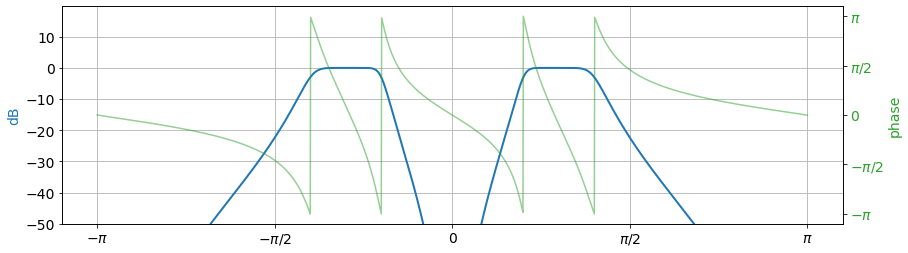

In [4]:
if __name__ == '__main__':
    frequency_response(b, a, dB=-50, half=False)

## Pole-zero plot

In [5]:
def zplane(b, a, axis=None):
    """plot the poles and zeros of a digital filter"""
    p = np.roots(a)
    z = np.roots(b)

    if axis is None:
        _, axis = plt.subplots()
    axis.plot(z.real, z.imag, 'C0o', ms=10)
    axis.plot(p.real, p.imag, 'C3x', ms=10, markeredgewidth=3.0)
    axis.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), 'k:')
    axis.spines['left'].set_position(("data", 0))
    axis.spines['bottom'].set_position(("data", 0))
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.axis('square')

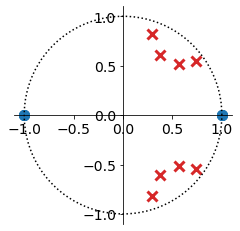

In [6]:
if __name__ == '__main__':
    zplane(b, a)

## ... and both at the same time

In [7]:
def filter_props(b, a, half=False, dB=False, points=2001):
    fig, (af, ap) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.3})
    frequency_response(b, a, half=half, dB=dB, points=points, axis=af)
    zplane(b, a, axis=ap)

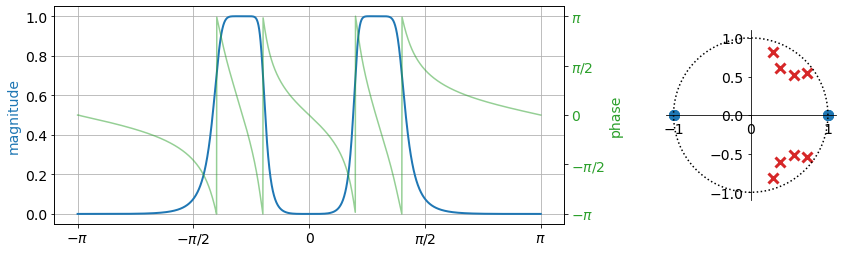

In [8]:
if __name__ == '__main__':
    filter_props(b, a)

## Analog magnitude response

In audio applications it is customary to plot the magnitude response on a logarithmic frequency scale in Hz

In [9]:
def analog_response(b, a, sf, dB=-100, half=True, points=2001, axis=None, color='C0'):
    """plot the magnitude response of a digital filter on a log-log scale"""
    EPS = 1e-20
    w = np.linspace(0, np.pi, points)
    A, B = np.zeros(points, dtype='complex'), np.zeros(points, dtype='complex')
    for n, bn in enumerate(b):
        B += bn * np.exp(-1j * n * w)
    for n, an in enumerate(a):
        A += an * np.exp(-1j * n * w)
    M = 20 * np.log10(np.abs(np.where(B == 0, EPS, B) / (np.where(A == 0, EPS, A))))
    
    if axis is None:
        _, axis = plt.subplots()
    axis.plot(np.linspace(0, sf / 2, points), M, color, lw=2)
    axis.set_xscale('log')
    axis.set_ylabel('dB', color='C0')
    axis.grid(b=True, which='both')    
    axis.axis('tight')
    axis.set_ylim([max(dB, min(M)), None])    

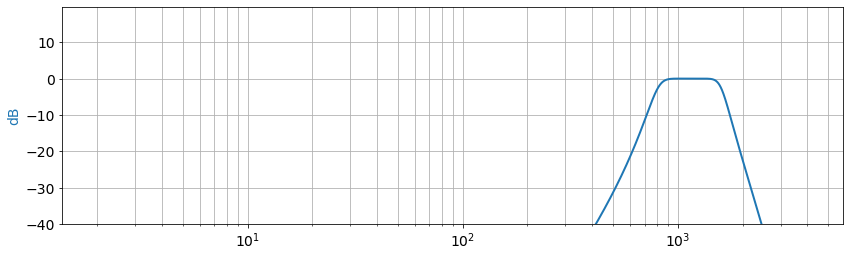

In [10]:
if __name__ == '__main__':
    analog_response(b, a, 8000, dB=-40)

# Filtering utilities

Normal filtering of a data sequence can be achieved with scipy's `lfilter`

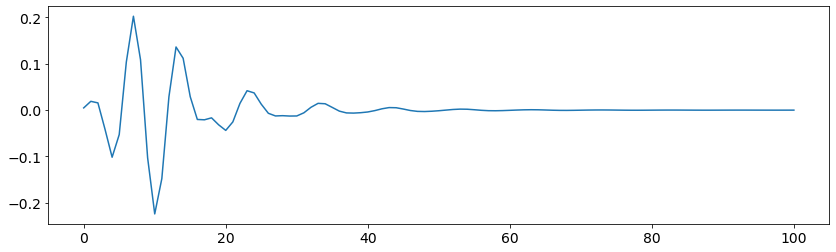

In [11]:
if __name__ == '__main__':
    from scipy import signal
    y = signal.lfilter(b, a, np.r_[1, np.zeros(100)])
    plt.plot(y)

## Stateful filtering

This is not very efficient but allows for successive calls with status preservation

In [12]:
class IIR:
    def __init__(self, b, a):
        assert a[0] == 1
        L = max(len(a), len(b))
        self.a, self.b = np.zeros(L), np.zeros(L)
        self.a[:len(a)] = a
        self.b[:len(b)] = b
        self.buf = np.zeros((2, L))

    def reset(self):
        self.buf *= 0.0

    def filter(self, x):
        y = np.zeros(len(x))
        for n, xn in enumerate(x):
            self.buf[:,0] = [xn, 0]
            y[n] = self.buf[1][0] = self.b @ self.buf[0] - self.a @ self.buf[1]
            self.buf = np.roll(self.buf, 1, axis=1)
        return y

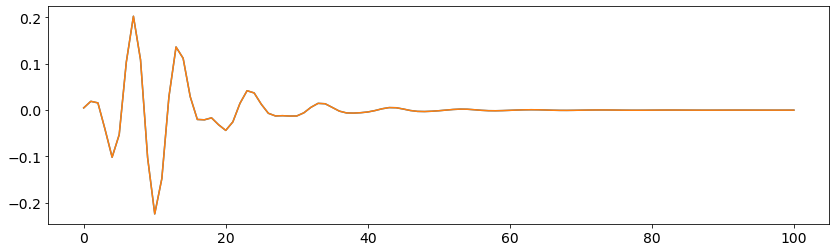

In [13]:
if __name__ == '__main__':
    bp = IIR(b, a)
    
    # one go:
    x = np.r_[1, np.zeros(100)]
    plt.plot(bp.filter(x))
    
    # sample by sample:
    for n, v in enumerate(x):
        x[n] = bp.filter([v])
    plt.plot(x)